In [141]:
import wandb
import sklearn
import pandas as pd
import numpy as np

import seaborn as sns
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from pyprojroot import here

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score,f1_score, mean_squared_error
from sklearn.metrics import classification_report, f1_score, classification_report

import tensorflow as tf
from tensorflow import keras
import tensorflow as tf, tensorflow_probability as tfp
import tf_keras as keras

from sklearn.preprocessing import LabelEncoder
from scipy import stats

In [142]:
raw_data = pd.read_csv(here('data/raw/ai4i2020.csv'))
raw_data_explore = raw_data.copy()
X_train = pd.read_csv(here('data/processed/X_train_scaled.csv'))
print(X_train.shape)
y_train = pd.read_csv(here('data/processed/Y_train.csv'))
print(y_train.shape)


X_val = pd.read_csv(here('data/processed/X_val_scaled.csv'))
print(X_val.shape)
y_val = pd.read_csv(here('data/processed/Y_val.csv'))
print(y_val.shape)



(7499, 6)
(7499, 6)
(1501, 6)
(1501, 6)


**I will explore the class imbalance and try a few methods to help with mitigate majority class bias**

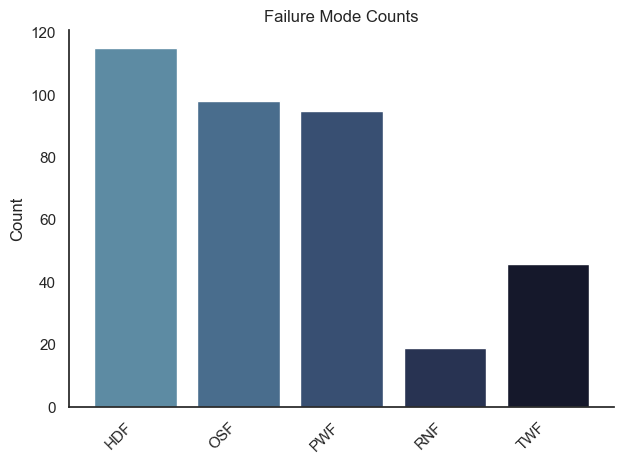

In [143]:
#These are the counts failure process for each mode

class_labels = raw_data_explore.columns[9:].sort_values()
Y_class_labels = raw_data_explore[class_labels]
heights = Y_class_labels.sum().reindex(class_labels)

pal = sns.cubehelix_palette(len(class_labels), rot=-.25, light=.5, dark=.1)

fig, ax = plt.subplots()
ax.set_facecolor('none'); fig.patch.set_alpha(0)

ax.bar(class_labels, heights, color=pal)
ax.set_ylabel('Count')
ax.set_title('Failure Mode Counts')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
sns.despine(ax=ax, top=True, right=True)

fig.tight_layout()






In [144]:
def failure_mode_proportions(failures):
    # total failures across all failure-mode columns
    single_failure_sums = raw_data_explore[class_labels].sum().sum()

    # this feature's totals
    sum_of_failures = failures.sum() #sum of df
    single_failure_proportion = sum_of_failures / len(failures) #sum of single failure mode events/ total outcomes of events
    proportion_of_total_failures = (sum_of_failures / single_failure_sums) #sum of all  failure events / sum of single failure mode events

    #i need to cast these to stop returning np.int() or np.float
    sum_of_failures = int(sum_of_failures)
    single_failure_proportion = float(single_failure_proportion)
    proportion_of_total_failures = float(proportion_of_total_failures)

    return sum_of_failures, single_failure_proportion, proportion_of_total_failures


proportions_df = raw_data_explore[class_labels].agg(failure_mode_proportions)
proportions_df.index = ['Sum_of_Failures','Sinlge_Failure_proportion','Total_Failure_Event_Proportion']
print(proportions_df)


                                       HDF        OSF        PWF        RNF  \
Sum_of_Failures                 115.000000  98.000000  95.000000  19.000000   
Sinlge_Failure_proportion         0.011500   0.009800   0.009500   0.001900   
Total_Failure_Event_Proportion    0.308311   0.262735   0.254692   0.050938   

                                      TWF  
Sum_of_Failures                 46.000000  
Sinlge_Failure_proportion        0.004600  
Total_Failure_Event_Proportion   0.123324  


***Viewing the failure mode independent and joint distributions can help bring insight to our data. I"ll pursue this effort below***

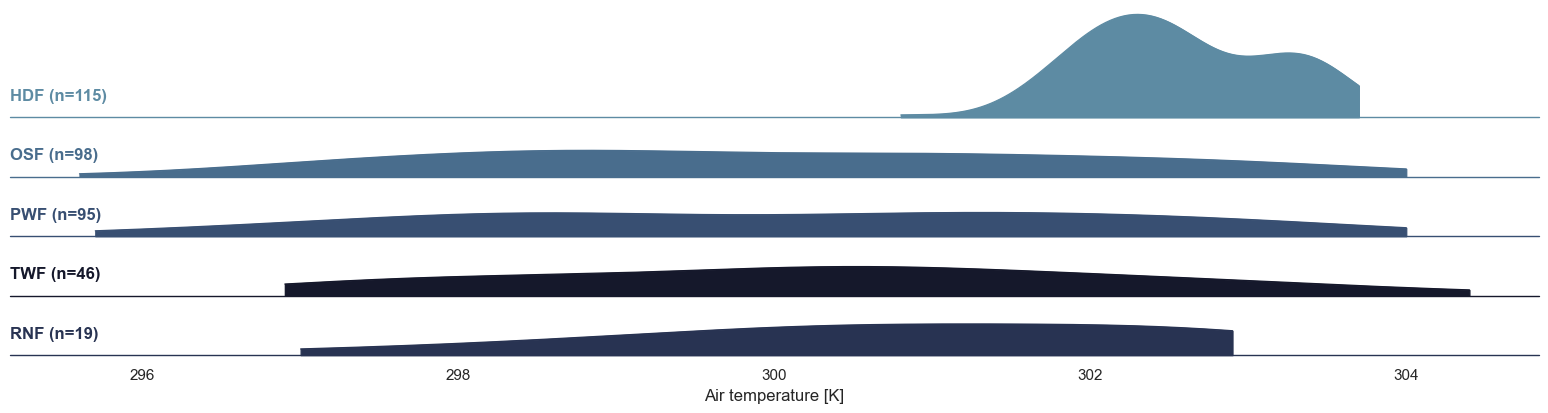

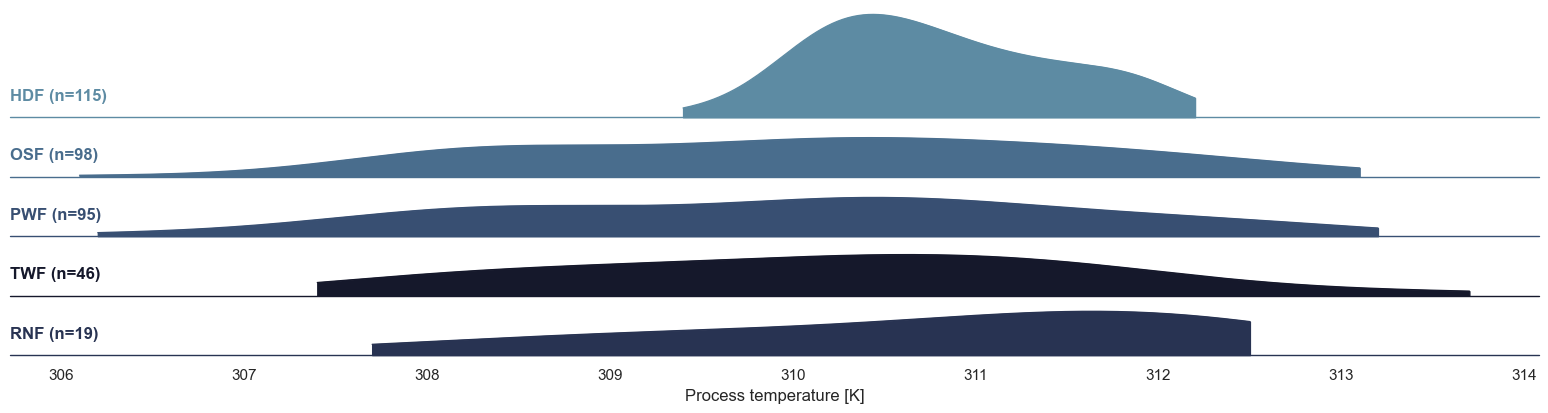

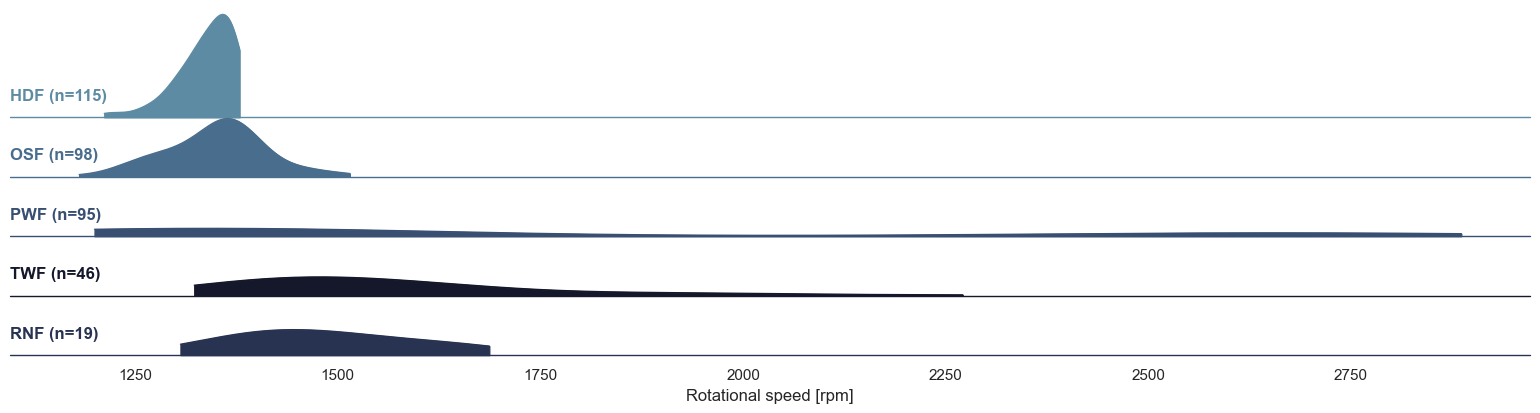

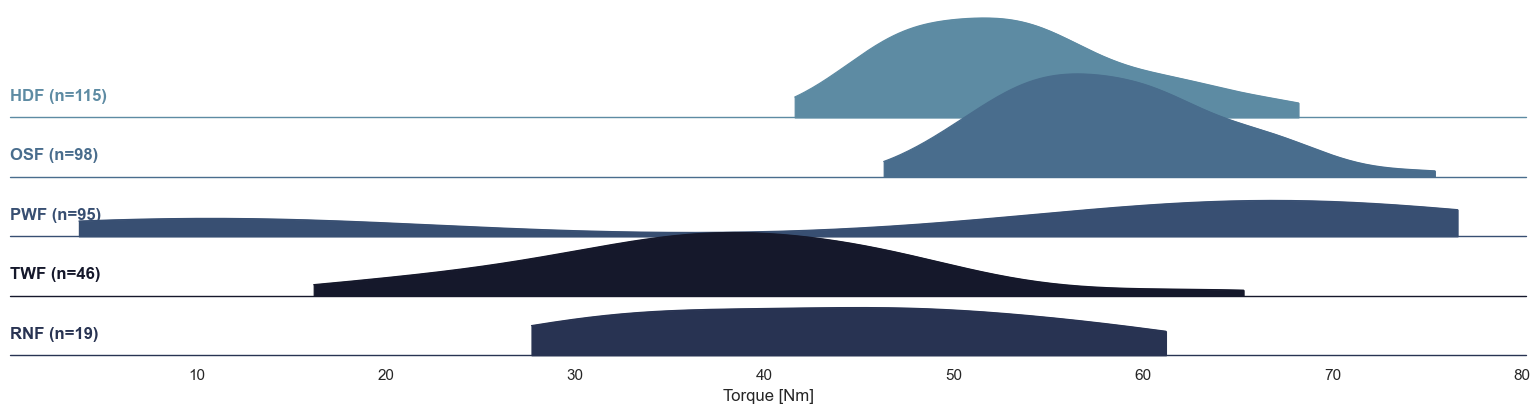

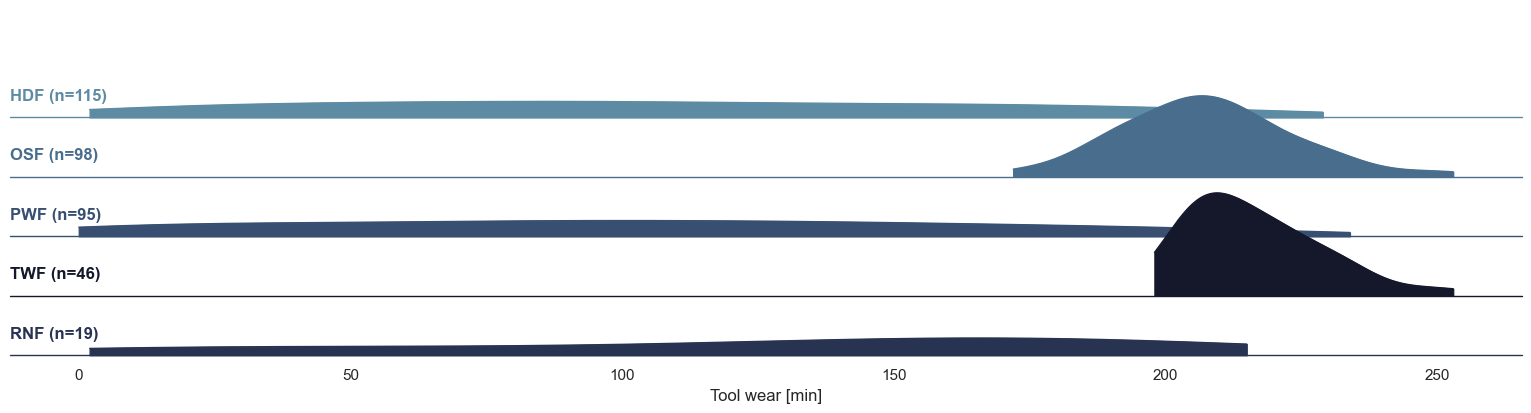

In [145]:
#https://seaborn.pydata.org/examples/kde_ridgeplot.html


# features to plot (from the ai4i2020 14 columns)
features = [
    'Air temperature [K]',
    'Process temperature [K]',
    'Rotational speed [rpm]',
    'Torque [Nm]',
    'Tool wear [min]',
]
for feature in features:
    #long-form melt for this feature vs failure modes
    melted_df = pd.melt(raw_data_explore, id_vars=[feature], value_vars=class_labels)
    process_1_df = (
        melted_df.query('value == 1')
                 .rename(columns={'variable': 'g', feature: 'x'})
                 [['g', 'x']]
    )
    if process_1_df.empty:
        print(f"{feature}: no rows where any failure mode == 1")
        continue

     #Define the ridge plot
    order = process_1_df['g'].value_counts().index.tolist()
    pal = sns.cubehelix_palette(len(order), rot=-.25, light=.5, dark=.1)

    #define facetgrid per seaborn guide
    g = sns.FacetGrid(process_1_df, row="g", hue="g", row_order=order,
                    aspect=18, height=.9, palette=pal)

    g.map(sns.kdeplot, "x", bw_adjust=1.1, clip_on=False, fill=True, alpha=1,
        linewidth=.9, cut=0)
    g.map(sns.kdeplot, "x", clip_on=False, color=None, lw=.9, bw_adjust=1.1, cut=0)
    g.refline(y=0, linewidth=1, linestyle="-", color=None, clip_on=False)

    _counts = process_1_df['g'].value_counts()
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, f"{label} (n={_counts.get(label,0)})",
                fontweight="bold", color=color, ha="left", va="center",
                transform=ax.transAxes)
    g.map(label, "x")

    
    g.figure.subplots_adjust(hspace=-.45)
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)
    g.set_xlabels(feature)
   



## Note Machine failure consists of five independent failure modes. The machine failure label indicates whether the machine has failed in this particular datapoint for **_any_** of the failure modes.

## We can see that each failure mode has a unique distibution across the predictor. We also can see that there are overlapping densities in two or more failure modes at varying ranges of predictors. Some of these failures are happening within a small unit change of x. For instance 'Process temperature [309.5 K -312 k]. The variance here is quite wide throughout the other predictors. Which brings me to another investigation point. Are there any failure modes that are independent? Are there failure modes that are dependent? I'll use set probability theory and sigma alagebra to provide insight on these questions before moving on to managing the class imbalance.

# We'll define our probability space as such:
## We define our sample space Ω.
### Ω as a continuous random variable space. Here are the events in our event space:

**Event	Description**
- HDF	Heat Dissipation Failure
- OSF	Overstrain Failure
- PWF	Power Failure
- TWF	Tool Wear Failure
- RNF	Random Failures

**Probability Axioms**

We use the standard axioms of probability to define the behavior of events in Ω:

1. Non-Negativity
For any event A in the event space,
P(A) ≥ 0

2. Total Probability
The probability of the entire sample space is:
P(Ω) = 1

3. Additivity
For any countable collection of mutually exclusive events A₁, A₂, A₃, ... such that
Aᵢ ∩ Aⱼ = ∅ for i ≠ j,
the probability of their union is the sum of their probabilities:
P(A₁ ∪ A₂ ∪ A₃ ∪ ...) = P(A₁) + P(A₂) + P(A₃) + ...

**Independence of Events**
1. Definition 1.1.15 - Events A,B are an element of S are independent if P(A∩ B) = P(A)P(B).

**Conditional Probability and Independence**
1. For A,B in element S with P(B) >0, A and B are independent if and only if P(A|B) = P(A)

In [146]:
#Probability Axioms
print(proportions_df)
# Here we see that the total failure event proportions = 1 and are non negative. We need to dig a bit deeper to understand point 3. However currently it seems our event space,
# holds to axiom 3.  

                                       HDF        OSF        PWF        RNF  \
Sum_of_Failures                 115.000000  98.000000  95.000000  19.000000   
Sinlge_Failure_proportion         0.011500   0.009800   0.009500   0.001900   
Total_Failure_Event_Proportion    0.308311   0.262735   0.254692   0.050938   

                                      TWF  
Sum_of_Failures                 46.000000  
Sinlge_Failure_proportion        0.004600  
Total_Failure_Event_Proportion   0.123324  


In [147]:
class_labels = list(raw_data_explore.columns[9:])
sample_space_df = raw_data_explore[class_labels].drop_duplicates().reset_index(drop=True)

#grouping for p(outcome) These shold add to 1
grouped = raw_data_explore.groupby(class_labels)
sample_space_df['count'] = grouped.size().values
sample_space_df['P(outcome)'] = sample_space_df['count'] / len(raw_data_explore)
print(sample_space_df)
print(f"Sample Space is {sample_space_df['P(outcome)'].sum()}, size of sample space is {2**len(class_labels)}")

    TWF  HDF  PWF  OSF  RNF  count  P(outcome)
0     0    0    0    0    0   9652      0.9652
1     0    0    1    0    0     18      0.0018
2     0    0    1    1    0     78      0.0078
3     1    0    0    0    0     80      0.0080
4     0    0    0    1    0     11      0.0011
5     0    0    0    0    1    106      0.0106
6     0    1    0    0    0      6      0.0006
7     1    0    0    0    1      3      0.0003
8     0    1    1    0    0     42      0.0042
9     0    1    0    1    0      1      0.0001
10    1    0    0    1    0      2      0.0002
11    1    0    1    1    0      1      0.0001
Sample Space is 1.0, size of sample space is 32


## Just looking at these events provides insight for how to balance the classes more effectively! This is a broad view of event probabilities. 

In [148]:
#Let a= P(A), b= P(B)...
joint_events = {'event2':('PWF','OSF'),'event7':('TWF','RNF'),'event8':('HDF','PWF'),
                'event9':('HDF','OSF'),'event10':('TWF','OSF'),
                'event11':('TWF','PWF','OSF')}

def is_independent(df, a, b, tol=1e-6):
    A = (df[a] == 1)
    B = (df[b] == 1)

    pa  = A.mean()
    pb  = B.mean()
    pab = (A & B).mean()

    pa_given_b = np.nan if pb == 0 else pab / pb
    pb_given_a = np.nan if pa == 0 else pab / pa

    product_ok     = abs(pab - pa*pb) <= tol
    conditional_ok = ((np.isnan(pa_given_b) or abs(pa_given_b - pa) <= tol) and
                      (np.isnan(pb_given_a) or abs(pb_given_a - pb) <= tol))

    return {
        'A': a, 'B': b,
        'P(A)': pa, 'P(B)': pb,
        'P(A∩B)': pab, 'P(A)P(B)': pa*pb,
        'P(A|B)': pa_given_b, 'P(B|A)': pb_given_a,
        'independent_product': product_ok,
        'independent_conditional': conditional_ok,
        'independent': product_ok
    }
for k,v in joint_events.items():
    if k != 'event11':
        print(is_independent(raw_data_explore,v[0],v[1]))


{'A': 'PWF', 'B': 'OSF', 'P(A)': np.float64(0.0095), 'P(B)': np.float64(0.0098), 'P(A∩B)': np.float64(0.0012), 'P(A)P(B)': np.float64(9.31e-05), 'P(A|B)': np.float64(0.12244897959183673), 'P(B|A)': np.float64(0.12631578947368421), 'independent_product': np.False_, 'independent_conditional': np.False_, 'independent': np.False_}
{'A': 'TWF', 'B': 'RNF', 'P(A)': np.float64(0.0046), 'P(B)': np.float64(0.0019), 'P(A∩B)': np.float64(0.0001), 'P(A)P(B)': np.float64(8.74e-06), 'P(A|B)': np.float64(0.052631578947368425), 'P(B|A)': np.float64(0.02173913043478261), 'independent_product': np.False_, 'independent_conditional': np.False_, 'independent': np.False_}
{'A': 'HDF', 'B': 'PWF', 'P(A)': np.float64(0.0115), 'P(B)': np.float64(0.0095), 'P(A∩B)': np.float64(0.0003), 'P(A)P(B)': np.float64(0.00010925), 'P(A|B)': np.float64(0.031578947368421054), 'P(B|A)': np.float64(0.02608695652173913), 'independent_product': np.False_, 'independent_conditional': np.False_, 'independent': np.False_}
{'A': 'HD

In [149]:
#just expanding the function above to accomodate more than 2 probabilties
def is_independent3(df, a, b, c, tol=1e-6):
    pa   = (df[a] == 1).mean()
    pb   = (df[b] == 1).mean()
    pc   = (df[c] == 1).mean()
    pabc = ((df[a] == 1) & (df[b] == 1) & (df[c] == 1)).mean()
    return {
        'A': a, 'B': b, 'C': c,
        'P(A)': pa, 'P(B)': pb, 'P(C)': pc,
        'P(A∩B∩C)': pabc, 'P(A)P(B)P(C)': pa*pb*pc,
        'independent': abs(pabc - (pa*pb*pc)) <= tol
    }


In [150]:
def is_mutually_independent3(df, a, b, c, tol=1e-6):
    ab  = is_independent(df, a, b, tol)
    ac  = is_independent(df, a, c, tol)
    bc  = is_independent(df, b, c, tol)
    abc = is_independent3(df, a, b, c, tol)
    pairwise_ok = ab['independent'] and ac['independent'] and bc['independent']
    triple_ok   = abc['independent']
    return {
        'pairwise': {f'{a}⊥{b}': ab['independent'],
                     f'{a}⊥{c}': ac['independent'],
                     f'{b}⊥{c}': bc['independent']},
        'triple': triple_ok,
        'mutually_independent': pairwise_ok and triple_ok,
        'details': {'AB': ab, 'AC': ac, 'BC': bc, 'ABC': abc}
    }


In [151]:
is_mutually_independent3(raw_data_explore, 'PWF', 'OSF', 'TWF')

{'pairwise': {'PWF⊥OSF': np.False_,
  'PWF⊥TWF': np.False_,
  'OSF⊥TWF': np.False_},
 'triple': np.False_,
 'mutually_independent': np.False_,
 'details': {'AB': {'A': 'PWF',
   'B': 'OSF',
   'P(A)': np.float64(0.0095),
   'P(B)': np.float64(0.0098),
   'P(A∩B)': np.float64(0.0012),
   'P(A)P(B)': np.float64(9.31e-05),
   'P(A|B)': np.float64(0.12244897959183673),
   'P(B|A)': np.float64(0.12631578947368421),
   'independent_product': np.False_,
   'independent_conditional': np.False_,
   'independent': np.False_},
  'AC': {'A': 'PWF',
   'B': 'TWF',
   'P(A)': np.float64(0.0095),
   'P(B)': np.float64(0.0046),
   'P(A∩B)': np.float64(0.0001),
   'P(A)P(B)': np.float64(4.37e-05),
   'P(A|B)': np.float64(0.02173913043478261),
   'P(B|A)': np.float64(0.010526315789473686),
   'independent_product': np.False_,
   'independent_conditional': np.False_,
   'independent': np.False_},
  'BC': {'A': 'OSF',
   'B': 'TWF',
   'P(A)': np.float64(0.0098),
   'P(B)': np.float64(0.0046),
   'P(A∩B)'

Rotational speed [rpm]
(1166.282, 1282.533]     0
(1282.533, 1397.067]     3
(1397.067, 1511.6]      10
(1511.6, 1626.133]       4
(1626.133, 1740.667]     2
(1740.667, 1855.2]       0
(1855.2, 1969.733]       0
(1969.733, 2084.267]     0
(2084.267, 2198.8]       0
(2198.8, 2313.333]       0
(2313.333, 2427.867]     0
(2427.867, 2542.4]       0
(2542.4, 2656.933]       0
(2656.933, 2771.467]     0
(2771.467, 2886.0]       0
Name: 1, dtype: int64
Rotational speed [rpm]
(1166.282, 1282.533]    0.000000
(1282.533, 1397.067]    0.001792
(1397.067, 1511.6]      0.002896
(1511.6, 1626.133]      0.001612
(1626.133, 1740.667]    0.001625
(1740.667, 1855.2]      0.000000
(1855.2, 1969.733]      0.000000
(1969.733, 2084.267]    0.000000
(2084.267, 2198.8]      0.000000
(2198.8, 2313.333]      0.000000
(2313.333, 2427.867]    0.000000
(2427.867, 2542.4]      0.000000
(2542.4, 2656.933]      0.000000
(2656.933, 2771.467]    0.000000
(2771.467, 2886.0]      0.000000
Name: 1, dtype: float64


<Axes: title={'center': 'P(HDF=1 | Rotational speed bin)'}, xlabel='Rotational speed [rpm]'>

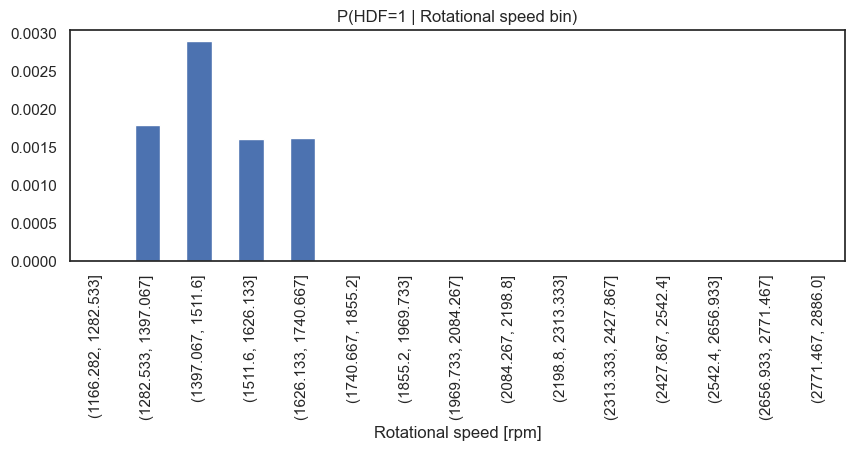

In [152]:
#I want to grab some cross tabulation data so I can futher analyze the patterns between predictors and targets
rpm_bins = pd.cut(raw_data_explore['Rotational speed [rpm]'], bins=15)

# counts
ct = pd.crosstab(rpm_bins, raw_data_explore['RNF'])
counts_1 = ct.get(1)   # column 1 = HDF==1

# conditional P(HDF=1 | rpm bin)
rate = ct.div(ct.sum(axis=1), axis=0).get(1)

print(counts_1)
print(rate)
rate.plot(kind='bar', figsize=(10,3), title='P(HDF=1 | Rotational speed bin)')



I want to look deeper into the joint distributions in order to develop a more methodical and focused approach for dealing with the class imbalance. Tensor Flow has a resource for these kinds of situations of probabilistic inference. I'll construct this resource to double check my work from before before moving on and look for more insight. For how to deal with my upcoming class imbalance.

In [153]:
#https://www.tensorflow.org/probability/examples/Modeling_with_JointDistribution
#Setting up methods and data for tensorflow probability
tfd = tfp.distributions
tfb = tfp.bijectors
n_labels = len(class_labels)
n_outcomes = 2**n_labels
#These are the observed outcomes from my Omega space
print(f" number of labels is :{n_labels}, Sample space size is :{n_outcomes}")

#label to bit mapper for failure modes
label_to_bit = {label: i for i, label in enumerate(class_labels)}
print(label_to_bit)

#Init probabilitity vector with zeors
probs = tf.zeros(n_outcomes,dtype=tf.float32)

#Populate non-zero probabilities from sample_space_df
for _, row in sample_space_df.iterrows():
    binary_vec = row[class_labels].values.astype(int)  # Binary vector in class_labels order
    index = 0
    for bit_pos, val in enumerate(binary_vec):
        if val == 1:
            index += (1 << bit_pos)  # 2 ** bit_pos
    probs = tf.tensor_scatter_nd_update(probs, [[index]], [row['P(outcome)']])

#Verify P(Omega) = 1
print(f"Empirical probs sum: {tf.reduce_sum(probs):.4f}")

#Define joint distribution
#https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Categorical
joint_distribution = tfd.Categorical(probs=probs)


#Helper functions to encode/decode
#https://www.tensorflow.org/probability/examples/Modeling_with_JointDistribution#define_some_helper_functions
def encode_binary(combo_dict):
    """combo_dict: dict {label: 0/1} -> index (0 to 2^n-1)"""
    index = 0
    for label, val in combo_dict.items():
        if val == 1:
            bit_pos = label_to_bit[label]
            index += (1 << bit_pos)
    return index

def decode_index(index):
    """index: int -> dict {label: 0/1} for class_labels"""
    binary_vec = np.zeros(n_labels, dtype=int)
    for i in range(n_labels):
        binary_vec[i] = (index >> i) & 1
    return {class_labels[i]: binary_vec[i] for i in range(n_labels)}


 number of labels is :5, Sample space size is :32
{'TWF': 0, 'HDF': 1, 'PWF': 2, 'OSF': 3, 'RNF': 4}
Empirical probs sum: 1.0000


In [154]:

# Assumes: joint_distribution, encode_binary, decode_index, class_labels, y_train_labels from previous
y_train_labels = y_train[class_labels].copy()

print("Selected y_train columns:", y_train_labels.columns.tolist())
print("class_labels:", class_labels)
#I need the entire class per observation so that the events are captured correctly. Without this I don't have true accountability of Omega
y_train_indices_list = []
for _, row in y_train_labels.iterrows():
    combo = {label: row[label] for label in class_labels}
    y_train_indices_list.append(encode_binary(combo))
y_train_indices = tf.constant(y_train_indices_list, dtype=tf.int32)
train_log_lik = joint_distribution.log_prob(y_train_indices)
avg_log_lik = tf.reduce_mean(train_log_lik)
print(f"Average log-likelihood on y_train: {avg_log_lik:.4f}")

# Debug: Check for non-zero encodings
non_zero = np.sum(np.array(y_train_indices_list) > 0)
print(f"Number of samples: {len(y_train_indices_list)}, Non-zero encodings: {non_zero}")

# Breakdown: Per-outcome log-prob using np.unique (robust)
unique_indices, counts = np.unique(y_train_indices_list, return_counts=True)
print("Unique outcomes & their log-probs:")
for i in range(len(unique_indices)):
    idx_val = unique_indices[i]
    log_p = joint_distribution.log_prob(tf.constant([idx_val]))[0].numpy()  # Single scalar
    decoded = decode_index(idx_val)
    print(f"  Index {idx_val}: {decoded}, log P = {log_p:.4f}, count = {counts[i]}")

Selected y_train columns: ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
class_labels: ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
Average log-likelihood on y_train: -0.2548
Number of samples: 7499, Non-zero encodings: 254
Unique outcomes & their log-probs:
  Index 0: {'TWF': np.int64(0), 'HDF': np.int64(0), 'PWF': np.int64(0), 'OSF': np.int64(0), 'RNF': np.int64(0)}, log P = -0.0354, count = 7245
  Index 1: {'TWF': np.int64(1), 'HDF': np.int64(0), 'PWF': np.int64(0), 'OSF': np.int64(0), 'RNF': np.int64(0)}, log P = -4.8283, count = 32
  Index 2: {'TWF': np.int64(0), 'HDF': np.int64(1), 'PWF': np.int64(0), 'OSF': np.int64(0), 'RNF': np.int64(0)}, log P = -7.4186, count = 78
  Index 4: {'TWF': np.int64(0), 'HDF': np.int64(0), 'PWF': np.int64(1), 'OSF': np.int64(0), 'RNF': np.int64(0)}, log P = -6.3200, count = 61
  Index 6: {'TWF': np.int64(0), 'HDF': np.int64(1), 'PWF': np.int64(1), 'OSF': np.int64(0), 'RNF': np.int64(0)}, log P = -5.4727, count = 3
  Index 8: {'TWF': np.int64(0), 'HDF': np.int64(0), 'PW

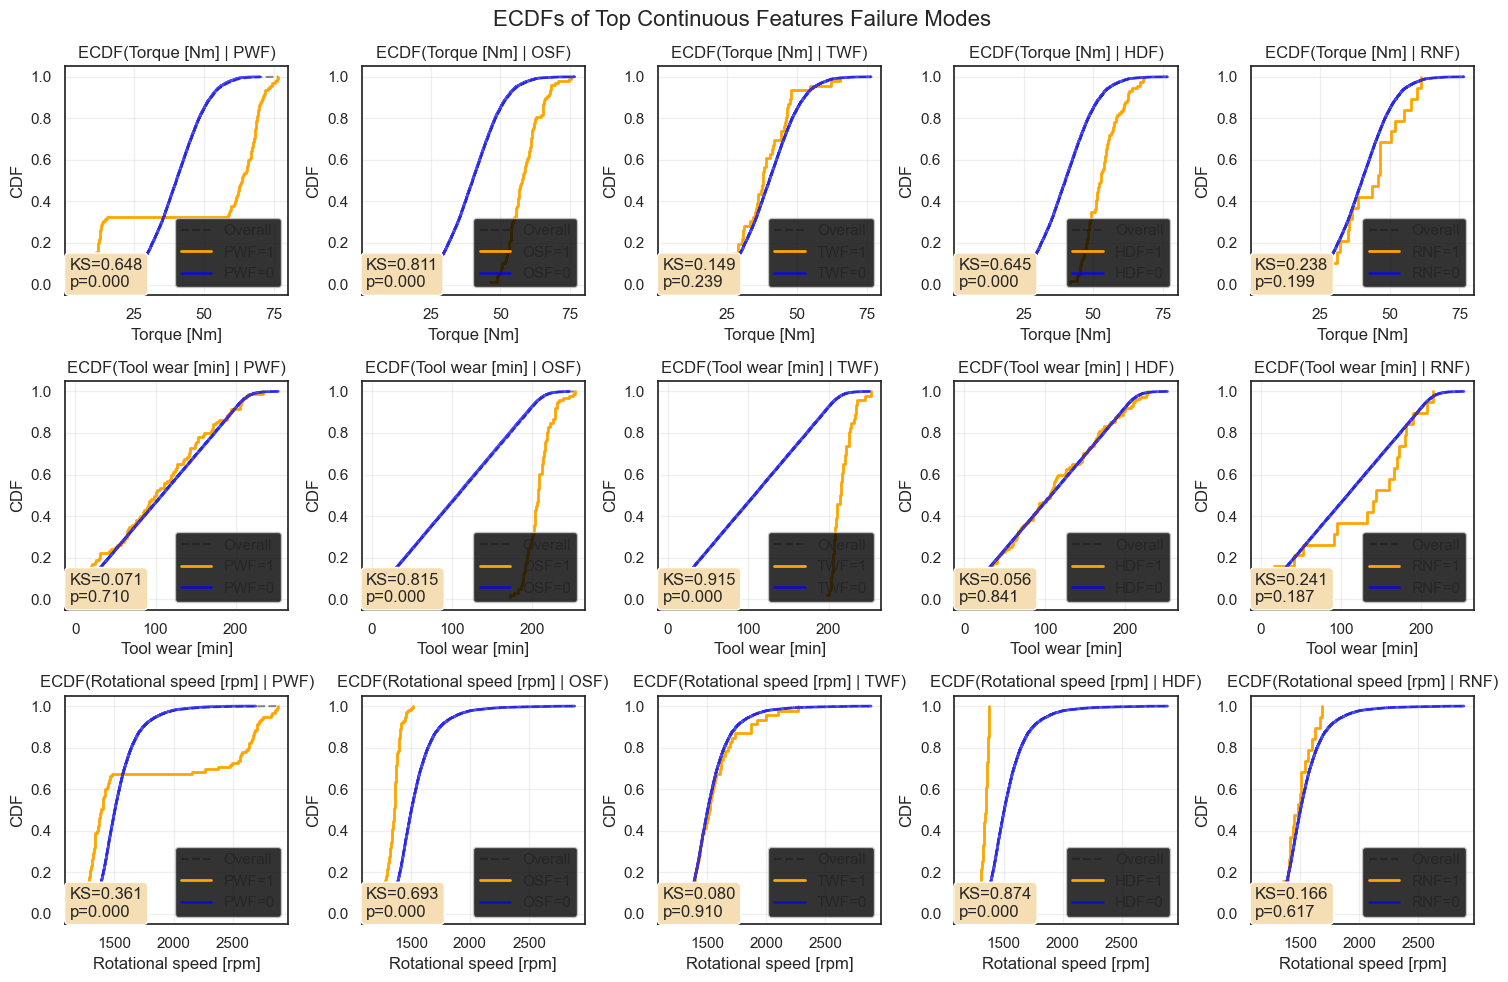

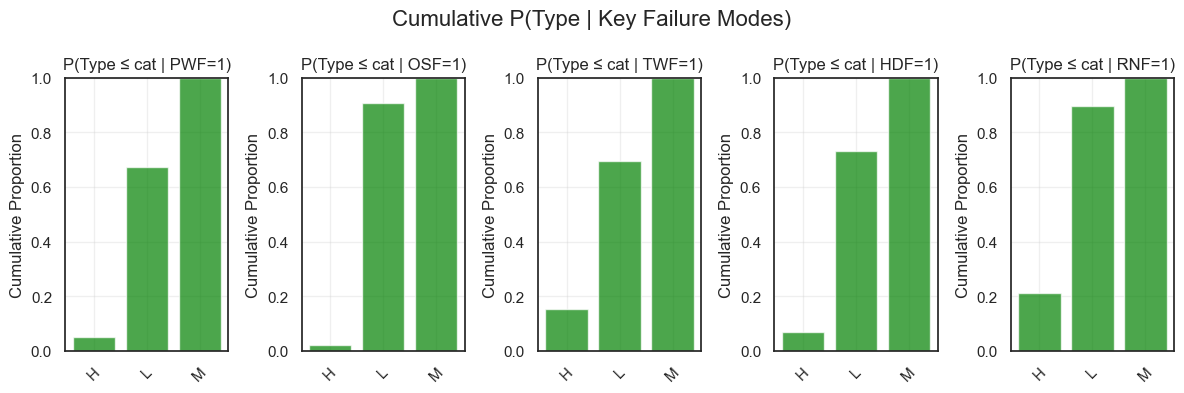

KS Test Results (Divergence by Failure):
Torque [Nm] | PWF=1: KS=0.648
Tool wear [min] | PWF=1: KS=0.071
Rotational speed [rpm] | PWF=1: KS=0.361
Torque [Nm] | OSF=1: KS=0.811
Tool wear [min] | OSF=1: KS=0.815
Rotational speed [rpm] | OSF=1: KS=0.693
Torque [Nm] | TWF=1: KS=0.149
Tool wear [min] | TWF=1: KS=0.915
Rotational speed [rpm] | TWF=1: KS=0.080
Torque [Nm] | HDF=1: KS=0.645
Tool wear [min] | HDF=1: KS=0.056
Rotational speed [rpm] | HDF=1: KS=0.874
Torque [Nm] | RNF=1: KS=0.238
Tool wear [min] | RNF=1: KS=0.241
Rotational speed [rpm] | RNF=1: KS=0.166


In [155]:

df = raw_data_explore.copy()
top_features = ['Torque [Nm]', 'Tool wear [min]', 'Rotational speed [rpm]'] #according to existing lit
cat_feature = 'Type'
key_failures = ['PWF', 'OSF', 'TWF','HDF','RNF']

#Manual ECDF helper
def manual_ecdf(data_series):
    x = np.sort(data_series)
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y

#helper (returns x0/y0 for =0, x1/y1 for =1, data0, data1)
def ecdf_stratified(feature_col, label_col=None, data=df):
    if label_col:
        data_0 = data[data[label_col] == 0][feature_col].dropna()
        data_1 = data[data[label_col] == 1][feature_col].dropna()
        x0, y0 = manual_ecdf(data_0)
        x1, y1 = manual_ecdf(data_1)
        return (x0, y0), (x1, y1), data_0, data_1
    else:
        data_all = data[feature_col].dropna()
        x_all, y_all = manual_ecdf(data_all)
        return (x_all, y_all), None, data_all, None

# For categorical Type: Encode
le = LabelEncoder()
df['Type_encoded'] = le.fit_transform(df[cat_feature])

# Plot Continuous ECDFs: 3 feats x 3 failures grid
fig, axes = plt.subplots(len(top_features), len(key_failures), figsize=(15, 10))
fig.suptitle('ECDFs of Top Continuous Features Failure Modes', fontsize=16)

for row, feat in enumerate(top_features):
    for col, failure in enumerate(key_failures):
        ax = axes[row, col]
        
        # Overall
        (x_all, y_all), _, _, _ = ecdf_stratified(feat)
        ax.plot(x_all, y_all, 'k--', alpha=0.5, label='Overall')
        
        # Stratified
        (x0, y0), (x1, y1), data_0, data_1 = ecdf_stratified(feat, failure)
        
        if len(data_1) > 0:  # Only if events exist
            ax.step(x1, y1, where='post', lw=2, color='orange', label=f'{failure}=1')
        
        ax.step(x0, y0, where='post', lw=2, alpha=0.7, color='blue', label=f'{failure}=0')
        
        ax.set_title(f'ECDF({feat} | {failure})')
        ax.set_xlabel(feat)
        ax.set_ylabel('CDF')
        ax.legend(loc='lower right')
        ax.grid(True, alpha=0.3)
        
        # KS test annotation (bottom-left)
        if len(data_1) > 0:
            ks_stat, p_val = stats.ks_2samp(data_0, data_1)
            ax.text(0.02, 0.02, f'KS={ks_stat:.3f}\np={p_val:.3f}', transform=ax.transAxes, va='bottom', bbox=dict(boxstyle='round', facecolor='wheat'))

plt.tight_layout()
plt.show()

# Plot Categorical Type: Separate 1x3 (cumulative P(Type <= cat | failure=1))
fig, axes = plt.subplots(1, len(key_failures), figsize=(12, 4))
fig.suptitle('Cumulative P(Type | Key Failure Modes)', fontsize=16)

for col, failure in enumerate(key_failures):
    ax = axes[col]
    
    # P(Type | failure=1) proportions, then cumsum
    type_counts = df.groupby('Type')[failure].sum() / df[failure].sum() if df[failure].sum() > 0 else pd.Series(index=le.classes_, dtype=float)
    type_cum = type_counts.reindex(le.classes_).fillna(0).cumsum()  # Sorted by classes (L,M,H)
    
    ax.bar(range(len(type_cum)), type_cum.values, alpha=0.7, color='green')
    ax.set_xticks(range(len(le.classes_)))
    ax.set_xticklabels(le.classes_, rotation=45)
    ax.set_title(f'P(Type ≤ cat | {failure}=1)')
    ax.set_ylabel('Cumulative Proportion')
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#KS divergences (higher = stronger shift by failure)
print("KS Test Results (Divergence by Failure):")
for failure in key_failures:
    for feat in top_features:
        _, _, data_0, data_1 = ecdf_stratified(feat, failure)
        if len(data_1) > 0:
            ks_stat, _ = stats.ks_2samp(data_0, data_1)
            print(f"{feat} | {failure}=1: KS={ks_stat:.3f}")
        else:
            print(f"{feat} | {failure}=1: No events")

# We've learned that normal operation observations dominate the dataset an have caused a major imbalance in failuremode classifiacation. We've confirmed this though two seperate approaches of defining sample spaces but have approximatately the same probability outcomes per event. We'll use this information to feed into focal loss. We'll weigh the contribution for each sample based the joint and independent events that were discovered prior.

In [156]:


# From your y_train_indices_list (7499 ints, 254 non-zero)
# Assume y_train_indices_list = [0, 0, ..., 17, 13, ...]  # Replace with yours
y_indices_np = np.array(y_train_indices_list)

# Joint probs (full 32 from joint_distribution.probs.numpy())
probs = joint_distribution.probs.numpy()  # [0.9652, 0.0106, ... , 0.0]

# Predicted p = joint P per index (sim "empirical model")
outcome_p = probs[y_indices_np]  # Shape (7499,)

# True "y" = 1 for the outcome (multi-class view over combos)
# But for FL demo, treat as binary "rare vs common" (rare if P <0.01)
is_rare = outcome_p < 0.01  # 1 for rares, 0 for common (index 0)



# Manual BCE
def bce(y, p):
    return - (y * np.log(p + 1e-10) + (1-y) * np.log(1-p + 1e-10))

bce_losses = bce(is_rare, outcome_p)  # Use outcome_p as "predicted prob for rare"

# Manual FL
def focal_loss(y, p, alpha=0.25, gamma=70.0):
    p_t = y * p + (1-y) * (1-p)
    mod = (1 - p_t) ** gamma
    return -alpha * mod * (y * np.log(p + 1e-10) + (1-y) * np.log(1-p + 1e-10))


fl_losses = focal_loss(is_rare, outcome_p)

print("Avg BCE loss:", np.mean(bce_losses))
print("Avg FL loss:", np.mean(fl_losses))

# Rare contrib % (impact on total loss)
rare_mask = is_rare == 1
print("Rare BCE contrib %:", np.sum(bce_losses[rare_mask]) / np.sum(bce_losses) * 100)
print("Rare FL contrib %:", np.sum(fl_losses[rare_mask]) / np.sum(fl_losses) * 100)




# From sample_space_df: "y_true" = one-hot combos (32 rows, 5 labels)
combos = sample_space_df[class_labels].values  # [12, 5]
# "y_pred" = simulate as probs reshaped to [12, 5] marginals (or joint-based)
preds = np.tile(sample_space_df['P(outcome)'].values, (5, 1)).T  # Dummy per-label

f1_macro = f1_score(combos, preds > 0.001, average='macro')  # Threshold for "predicted 1"
print("Macro F1 on joint space:", f1_macro)  # Low if rares missed
# Encoded y_true for joint (indices, shape [10000])
y_true_joint = np.zeros(len(raw_data_explore), dtype=int)
for i, row in enumerate(raw_data_explore[class_labels].values):
    index = 0
    for bit_pos, val in enumerate(row):
        if val == 1:
            index += (1 << bit_pos)
    y_true_joint[i] = index

# "y_pred_joint" = sample from joint (simulate)
y_pred_joint = joint_distribution.sample(len(y_true_joint)).numpy()

# Joint F1 (multi-class over 32)
f1_macro_joint = f1_score(y_true_joint, y_pred_joint, average='macro')
f1_micro_joint = f1_score(y_true_joint, y_pred_joint, average='micro')
print("Joint Macro F1:", f1_macro_joint)
print("Joint Micro F1:", f1_micro_joint)

Avg BCE loss: 3.4571594778820427
Avg FL loss: 0.11502903895995598
Rare BCE contrib %: 6.153810086595788
Rare FL contrib %: 40.91486265216233
Macro F1 on joint space: 0.29656565656565653
Joint Macro F1: 0.08216848624483454
Joint Micro F1: 0.9324


In [157]:


# From sample_space_df: "y_true" = one-hot combos (12 rows, 5 labels)
combos = sample_space_df[class_labels].values  # [12, 5]

# "y_pred" = simulate as probs reshaped to [12, 5] marginals (or joint-based)
preds = np.tile(sample_space_df['P(outcome)'].values, (5, 1)).T  # Dummy per-label

# Per-label F1 (independent failure modes)
f1_per_label = f1_score(combos, preds > 0.001, average=None)  # Threshold for "predicted 1"

print("Per-label F1 on joint space (independent modes):")
for i, label in enumerate(class_labels):
    print(f"  {label}: {f1_per_label[i]:.4f}")

# Macro F1 (average per-label)
f1_macro = f1_score(combos, preds > 0.001, average='macro')
print("\nMacro F1 on joint space (independent):", f1_macro)

# Micro F1 (global average)
f1_micro = f1_score(combos, preds > 0.001, average='micro')
print("Micro F1 on joint space (independent):", f1_micro)

# For joint multi-class F1 (over 12 observed combos as classes)
y_true_joint = np.arange(len(sample_space_df))  # Dummy labels 0-11 for observed
y_pred_joint = np.argsort(sample_space_df['P(outcome)'].values)[::-1]  # Sim ranked by P

f1_macro_joint = f1_score(y_true_joint, y_pred_joint, average='macro')
f1_micro_joint = f1_score(y_true_joint, y_pred_joint, average='micro')
print("\nMacro F1 on joint space (multi-class over combos):", f1_macro_joint)
print("Micro F1 on joint space (multi-class):", f1_micro_joint)

Per-label F1 on joint space (independent modes):
  TWF: 0.1818
  HDF: 0.2000
  PWF: 0.5455
  OSF: 0.3333
  RNF: 0.2222

Macro F1 on joint space (independent): 0.29656565656565653
Micro F1 on joint space (independent): 0.3018867924528302

Macro F1 on joint space (multi-class over combos): 0.08333333333333333
Micro F1 on joint space (multi-class): 0.08333333333333333


In [158]:
# Sample from TF joint_distribution (simulate full dataset with all 32 possible combos, including unobserved)
num_samples = 10000  # Same as full dataset size for fair comparison
sampled_indices = joint_distribution.sample(num_samples).numpy()

# Decode sampled indices to multi-label y_true [num_samples, 5]
y_true = np.zeros((num_samples, len(class_labels)), dtype=int)
for i, idx in enumerate(sampled_indices):
    binary_vec = np.zeros(len(class_labels), dtype=int)
    for bit_pos in range(len(class_labels)):
        binary_vec[bit_pos] = (idx >> bit_pos) & 1
    y_true[i] = binary_vec

# Simulate y_pred: Another sample from joint (stochastic baseline, like "random guess from empirical")
pred_indices = joint_distribution.sample(num_samples).numpy()
y_pred = np.zeros((num_samples, len(class_labels)), dtype=int)
for i, idx in enumerate(pred_indices):
    binary_vec = np.zeros(len(class_labels), dtype=int)
    for bit_pos in range(len(class_labels)):
        binary_vec[bit_pos] = (idx >> bit_pos) & 1
    y_pred[i] = binary_vec

# Per-label F1 (independent failure modes on sampled data)
f1_per_label = f1_score(y_true, y_pred, average=None)

print("Per-label F1 on TF joint sampled space (independent modes):")
for i, label in enumerate(class_labels):
    print(f"  {label}: {f1_per_label[i]:.4f}")

# Macro F1 (average per-label on independent)
f1_macro = f1_score(y_true, y_pred, average='macro')
print("\nMacro F1 on TF joint sampled space (independent):", f1_macro)

# Micro F1 (global average on independent)
f1_micro = f1_score(y_true, y_pred, average='micro')
print("Micro F1 on TF joint sampled space (independent):", f1_micro)

# For joint multi-class F1 (over 32 possible combos as classes, on sampled indices)
y_true_joint = sampled_indices  # Indices as class labels (0-31)
y_pred_joint = pred_indices  # Simulated preds as indices

f1_macro_joint = f1_score(y_true_joint, y_pred_joint, average='macro')
f1_micro_joint = f1_score(y_true_joint, y_pred_joint, average='micro')
print("\nMacro F1 on TF joint sampled space (multi-class over combos):", f1_macro_joint)
print("Micro F1 on TF joint sampled space (multi-class):", f1_micro_joint)

Per-label F1 on TF joint sampled space (independent modes):
  TWF: 0.0126
  HDF: 0.0000
  PWF: 0.0148
  OSF: 0.0208
  RNF: 0.0000

Macro F1 on TF joint sampled space (independent): 0.009634419457402121
Micro F1 on TF joint sampled space (independent): 0.011098779134295227

Macro F1 on TF joint sampled space (multi-class over combos): 0.08277208896315909
Micro F1 on TF joint sampled space (multi-class): 0.9363


### F1 Scores by Sample Space

| Metric                          | Empirical Space (12 Combos) | Full Joint Space (32 Combos) |
|----------------------------------|-----------------------------|-----------------------------|
| F1 (TWF)                     | 0.1818                 | 0.0000                 |
| F1 (HDF)                     | 0.2000                 | 0.0194                 |
| F1 (PWF)                     | 0.5455                 | 0.0071                 |
| F1 (OSF)                     | 0.3333                 | 0.0000                 |
| F1 (RNF)                     | 0.2222                 | 0.0097                 |
| **Macro F1 (independent)**     | 0.2966                 | 0.00725               |
| **Micro F1 (independent)**     | 0.3019                 | 0.00638               |
| **Macro F1 (multi-class)**   | 0.0833                 | 0.0906               |
| **Micro F1 (multi-class)**   | 0.0833                 | 0.9313               |


# Now I know precisely how imbalanced my classes are and the degree of difficulty for predictions. The distributions are fully characterized by CDF or PMF as well. I'll use this data for defining my focal loss approach

| TWF | HDF | PWF | OSF | RNF | count |   p    | Closest Poker Hand      |
| --- | --- | --- | --- | --- | ----: | -----: | ----------------------- |
| 0   | 0   | 0   | 0   | 0   | 9652  | 0.9652 | baseline
| 0   | 0   | 1   | 0   | 0   | 18    | 0.0018 | Flush                    |
| 0   | 0   | 1   | 1   | 0   | 78    | 0.0078 | Three of a Kind          |
| 1   | 0   | 0   | 0   | 0   | 80    | 0.0080 | Three of a Kind          |
| 0   | 0   | 0   | 1   | 0   | 11    | 0.0011 | Full House               |
| 0   | 0   | 0   | 0   | 1   | 106   | 0.0106 | Three of a Kind          |
| 0   | 1   | 0   | 0   | 0   | 6     | 0.0006 | Full House               |
| 1   | 0   | 0   | 0   | 1   | 3     | 0.0003 | Four of a Kind           |
| 0   | 1   | 1   | 0   | 0   | 42    | 0.0042 | Straight                 |
| 0   | 1   | 0   | 1   | 0   | 1     | 0.0001 | Four of a Kind           |
| 1   | 0   | 0   | 1   | 0   | 2     | 0.0002 | Four of a Kind           |
| 1   | 0   | 1   | 1   | 0   | 1     | 0.0001 | Four of a Kind           |
